In [3]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [4]:
borrar = ["Opportunity_Name", "ID", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "Actual_Delivery_Date", "Last_Activity", 
          "ASP_converted_Currency", "Prod_Category_A", "Product_Name", "Delivery_Year", 
          "TRF", "Product_Family", "Account_Name"]

useless = ["Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", "Price", "ASP_Currency", 
           "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type"]

dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date"]

target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [62]:
def preprocess(data):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = (data.Opportunity_Owner == data.Account_Owner) & (data.Opportunity_Owner == data.Last_Modified_By)
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort=False)["Opportunity_ID"].transform(lambda x: x.nunique())
    
    data["Concrete_Offer"] = (data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days < 60
    data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days
    
    # fabri
    
    data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    data["Month"] = data.Month.str[-2:].astype(int)
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(borrar + useless + dates + ["Delivery_Quarter"], axis = 1)
    
    #data.drop(data[(data.Contacts > 1) & (data.ASP.isna())].index, inplace = True)
    #data = data.drop_duplicates([x for x in data.columns if x != 'ID'])
    
    return (data)

In [6]:
import catboost as ctb

In [63]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [64]:
prep = preprocess(data)

In [65]:
prep = prep[(prep.Stage == "Closed Won") | (prep.Stage == "Closed Lost")]
prep.Stage = prep.Stage.replace({"Closed Won": 1, "Closed Lost": 0})

In [66]:
prep.Stage.value_counts()

1    9533
0    7350
Name: Stage, dtype: int64

In [67]:
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size=0.3, random_state=0)

In [68]:
cat_vars = [x for x in x_train.drop(target, axis=1).select_dtypes('category').columns if x != 'Stage']

In [70]:
cat_indexes = [x_train.drop(target, axis=1).columns.get_loc(x) for x in cat_vars]

In [71]:
model = ctb.CatBoostClassifier(num_boost_round=5000,
                               learning_rate=0.015,
                               l2_leaf_reg=3.5,
                               depth=8, 
                               max_bin=400,
                               num_leaves=31,
                               rsm=0.98,
                               eval_metric='Logloss',
                               use_best_model=True,
                               random_seed=42)

In [72]:
model.fit(x_train.drop(target, axis=1), y_train, eval_set=(x_test.drop(target, axis=1), y_test), cat_features=cat_indexes, early_stopping_rounds=800)

0:	learn: 0.6673771	test: 0.6674933	best: 0.6674933 (0)	total: 20.1ms	remaining: 1m 40s
1:	learn: 0.6427685	test: 0.6432238	best: 0.6432238 (1)	total: 37.5ms	remaining: 1m 33s
2:	learn: 0.6219508	test: 0.6226921	best: 0.6226921 (2)	total: 48ms	remaining: 1m 19s
3:	learn: 0.6002857	test: 0.6008479	best: 0.6008479 (3)	total: 61.6ms	remaining: 1m 16s
4:	learn: 0.5777949	test: 0.5786357	best: 0.5786357 (4)	total: 76.7ms	remaining: 1m 16s
5:	learn: 0.5566774	test: 0.5576673	best: 0.5576673 (5)	total: 91.6ms	remaining: 1m 16s
6:	learn: 0.5385384	test: 0.5395649	best: 0.5395649 (6)	total: 106ms	remaining: 1m 15s
7:	learn: 0.5216881	test: 0.5228678	best: 0.5228678 (7)	total: 113ms	remaining: 1m 10s
8:	learn: 0.5043217	test: 0.5060224	best: 0.5060224 (8)	total: 127ms	remaining: 1m 10s
9:	learn: 0.4873208	test: 0.4891505	best: 0.4891505 (9)	total: 137ms	remaining: 1m 8s
10:	learn: 0.4714841	test: 0.4734524	best: 0.4734524 (10)	total: 150ms	remaining: 1m 8s
11:	learn: 0.4558404	test: 0.4581011	be

93:	learn: 0.1241116	test: 0.1358448	best: 0.1358448 (93)	total: 1.48s	remaining: 1m 17s
94:	learn: 0.1233169	test: 0.1351562	best: 0.1351562 (94)	total: 1.5s	remaining: 1m 17s
95:	learn: 0.1224529	test: 0.1343706	best: 0.1343706 (95)	total: 1.52s	remaining: 1m 17s
96:	learn: 0.1217605	test: 0.1337964	best: 0.1337964 (96)	total: 1.54s	remaining: 1m 17s
97:	learn: 0.1211604	test: 0.1332848	best: 0.1332848 (97)	total: 1.55s	remaining: 1m 17s
98:	learn: 0.1204151	test: 0.1326299	best: 0.1326299 (98)	total: 1.57s	remaining: 1m 17s
99:	learn: 0.1197367	test: 0.1319982	best: 0.1319982 (99)	total: 1.59s	remaining: 1m 17s
100:	learn: 0.1193966	test: 0.1316617	best: 0.1316617 (100)	total: 1.59s	remaining: 1m 17s
101:	learn: 0.1187759	test: 0.1310610	best: 0.1310610 (101)	total: 1.61s	remaining: 1m 17s
102:	learn: 0.1183308	test: 0.1306332	best: 0.1306332 (102)	total: 1.63s	remaining: 1m 17s
103:	learn: 0.1177271	test: 0.1300376	best: 0.1300376 (103)	total: 1.65s	remaining: 1m 17s
104:	learn: 0.

189:	learn: 0.0917888	test: 0.1079197	best: 0.1079197 (189)	total: 3.17s	remaining: 1m 20s
190:	learn: 0.0915153	test: 0.1077032	best: 0.1077032 (190)	total: 3.19s	remaining: 1m 20s
191:	learn: 0.0913692	test: 0.1076092	best: 0.1076092 (191)	total: 3.21s	remaining: 1m 20s
192:	learn: 0.0912398	test: 0.1075158	best: 0.1075158 (192)	total: 3.22s	remaining: 1m 20s
193:	learn: 0.0911280	test: 0.1074157	best: 0.1074157 (193)	total: 3.24s	remaining: 1m 20s
194:	learn: 0.0909395	test: 0.1072467	best: 0.1072467 (194)	total: 3.26s	remaining: 1m 20s
195:	learn: 0.0907714	test: 0.1071302	best: 0.1071302 (195)	total: 3.27s	remaining: 1m 20s
196:	learn: 0.0905920	test: 0.1070174	best: 0.1070174 (196)	total: 3.29s	remaining: 1m 20s
197:	learn: 0.0903860	test: 0.1068113	best: 0.1068113 (197)	total: 3.31s	remaining: 1m 20s
198:	learn: 0.0902909	test: 0.1067548	best: 0.1067548 (198)	total: 3.32s	remaining: 1m 20s
199:	learn: 0.0901792	test: 0.1066649	best: 0.1066649 (199)	total: 3.34s	remaining: 1m 20s

290:	learn: 0.0776600	test: 0.0972874	best: 0.0972874 (290)	total: 4.86s	remaining: 1m 18s
291:	learn: 0.0775874	test: 0.0972197	best: 0.0972197 (291)	total: 4.87s	remaining: 1m 18s
292:	learn: 0.0775099	test: 0.0971627	best: 0.0971627 (292)	total: 4.89s	remaining: 1m 18s
293:	learn: 0.0773085	test: 0.0969492	best: 0.0969492 (293)	total: 4.91s	remaining: 1m 18s
294:	learn: 0.0772650	test: 0.0969330	best: 0.0969330 (294)	total: 4.92s	remaining: 1m 18s
295:	learn: 0.0771485	test: 0.0969014	best: 0.0969014 (295)	total: 4.94s	remaining: 1m 18s
296:	learn: 0.0770194	test: 0.0967839	best: 0.0967839 (296)	total: 4.96s	remaining: 1m 18s
297:	learn: 0.0768639	test: 0.0966176	best: 0.0966176 (297)	total: 4.98s	remaining: 1m 18s
298:	learn: 0.0767679	test: 0.0965137	best: 0.0965137 (298)	total: 4.99s	remaining: 1m 18s
299:	learn: 0.0766055	test: 0.0964286	best: 0.0964286 (299)	total: 5.01s	remaining: 1m 18s
300:	learn: 0.0765742	test: 0.0964071	best: 0.0964071 (300)	total: 5.03s	remaining: 1m 18s

391:	learn: 0.0683895	test: 0.0908184	best: 0.0908184 (391)	total: 6.54s	remaining: 1m 16s
392:	learn: 0.0683889	test: 0.0908174	best: 0.0908174 (392)	total: 6.54s	remaining: 1m 16s
393:	learn: 0.0682623	test: 0.0906840	best: 0.0906840 (393)	total: 6.56s	remaining: 1m 16s
394:	learn: 0.0682150	test: 0.0906645	best: 0.0906645 (394)	total: 6.58s	remaining: 1m 16s
395:	learn: 0.0681708	test: 0.0906318	best: 0.0906318 (395)	total: 6.59s	remaining: 1m 16s
396:	learn: 0.0681540	test: 0.0906177	best: 0.0906177 (396)	total: 6.61s	remaining: 1m 16s
397:	learn: 0.0681117	test: 0.0905949	best: 0.0905949 (397)	total: 6.62s	remaining: 1m 16s
398:	learn: 0.0680796	test: 0.0905685	best: 0.0905685 (398)	total: 6.64s	remaining: 1m 16s
399:	learn: 0.0679216	test: 0.0904340	best: 0.0904340 (399)	total: 6.66s	remaining: 1m 16s
400:	learn: 0.0678299	test: 0.0903729	best: 0.0903729 (400)	total: 6.67s	remaining: 1m 16s
401:	learn: 0.0677421	test: 0.0903155	best: 0.0903155 (401)	total: 6.69s	remaining: 1m 16s

483:	learn: 0.0630693	test: 0.0872912	best: 0.0872912 (483)	total: 7.96s	remaining: 1m 14s
484:	learn: 0.0630622	test: 0.0872813	best: 0.0872813 (484)	total: 7.97s	remaining: 1m 14s
485:	learn: 0.0630122	test: 0.0872428	best: 0.0872428 (485)	total: 7.99s	remaining: 1m 14s
486:	learn: 0.0629704	test: 0.0871850	best: 0.0871850 (486)	total: 8s	remaining: 1m 14s
487:	learn: 0.0629166	test: 0.0871556	best: 0.0871556 (487)	total: 8.02s	remaining: 1m 14s
488:	learn: 0.0629146	test: 0.0871540	best: 0.0871540 (488)	total: 8.03s	remaining: 1m 14s
489:	learn: 0.0628997	test: 0.0871477	best: 0.0871477 (489)	total: 8.04s	remaining: 1m 14s
490:	learn: 0.0628463	test: 0.0871183	best: 0.0871183 (490)	total: 8.06s	remaining: 1m 14s
491:	learn: 0.0628327	test: 0.0871108	best: 0.0871108 (491)	total: 8.07s	remaining: 1m 13s
492:	learn: 0.0627734	test: 0.0870724	best: 0.0870724 (492)	total: 8.09s	remaining: 1m 13s
493:	learn: 0.0626949	test: 0.0870130	best: 0.0870130 (493)	total: 8.11s	remaining: 1m 13s
49

576:	learn: 0.0590645	test: 0.0849755	best: 0.0849755 (576)	total: 9.45s	remaining: 1m 12s
577:	learn: 0.0590526	test: 0.0849843	best: 0.0849755 (576)	total: 9.47s	remaining: 1m 12s
578:	learn: 0.0589670	test: 0.0849472	best: 0.0849472 (578)	total: 9.48s	remaining: 1m 12s
579:	learn: 0.0588648	test: 0.0848464	best: 0.0848464 (579)	total: 9.5s	remaining: 1m 12s
580:	learn: 0.0588568	test: 0.0848415	best: 0.0848415 (580)	total: 9.52s	remaining: 1m 12s
581:	learn: 0.0587558	test: 0.0847452	best: 0.0847452 (581)	total: 9.53s	remaining: 1m 12s
582:	learn: 0.0586639	test: 0.0846751	best: 0.0846751 (582)	total: 9.55s	remaining: 1m 12s
583:	learn: 0.0586206	test: 0.0846746	best: 0.0846746 (583)	total: 9.57s	remaining: 1m 12s
584:	learn: 0.0586069	test: 0.0846750	best: 0.0846746 (583)	total: 9.58s	remaining: 1m 12s
585:	learn: 0.0585341	test: 0.0846547	best: 0.0846547 (585)	total: 9.6s	remaining: 1m 12s
586:	learn: 0.0585145	test: 0.0846249	best: 0.0846249 (586)	total: 9.62s	remaining: 1m 12s
5

667:	learn: 0.0548779	test: 0.0826084	best: 0.0826084 (667)	total: 10.9s	remaining: 1m 10s
668:	learn: 0.0548106	test: 0.0825938	best: 0.0825938 (668)	total: 10.9s	remaining: 1m 10s
669:	learn: 0.0548020	test: 0.0825891	best: 0.0825891 (669)	total: 11s	remaining: 1m 10s
670:	learn: 0.0547704	test: 0.0825910	best: 0.0825891 (669)	total: 11s	remaining: 1m 10s
671:	learn: 0.0547542	test: 0.0825872	best: 0.0825872 (671)	total: 11s	remaining: 1m 10s
672:	learn: 0.0546793	test: 0.0825436	best: 0.0825436 (672)	total: 11s	remaining: 1m 10s
673:	learn: 0.0546038	test: 0.0824843	best: 0.0824843 (673)	total: 11s	remaining: 1m 10s
674:	learn: 0.0544656	test: 0.0823824	best: 0.0823824 (674)	total: 11s	remaining: 1m 10s
675:	learn: 0.0543781	test: 0.0823544	best: 0.0823544 (675)	total: 11.1s	remaining: 1m 10s
676:	learn: 0.0543159	test: 0.0823209	best: 0.0823209 (676)	total: 11.1s	remaining: 1m 10s
677:	learn: 0.0543057	test: 0.0823238	best: 0.0823209 (676)	total: 11.1s	remaining: 1m 10s
678:	learn:

765:	learn: 0.0504487	test: 0.0803228	best: 0.0803228 (765)	total: 12.6s	remaining: 1m 9s
766:	learn: 0.0504060	test: 0.0803062	best: 0.0803062 (766)	total: 12.6s	remaining: 1m 9s
767:	learn: 0.0503446	test: 0.0802543	best: 0.0802543 (767)	total: 12.6s	remaining: 1m 9s
768:	learn: 0.0502747	test: 0.0802011	best: 0.0802011 (768)	total: 12.6s	remaining: 1m 9s
769:	learn: 0.0502139	test: 0.0801574	best: 0.0801574 (769)	total: 12.7s	remaining: 1m 9s
770:	learn: 0.0502104	test: 0.0801487	best: 0.0801487 (770)	total: 12.7s	remaining: 1m 9s
771:	learn: 0.0501582	test: 0.0801206	best: 0.0801206 (771)	total: 12.7s	remaining: 1m 9s
772:	learn: 0.0500838	test: 0.0800753	best: 0.0800753 (772)	total: 12.7s	remaining: 1m 9s
773:	learn: 0.0500459	test: 0.0800300	best: 0.0800300 (773)	total: 12.7s	remaining: 1m 9s
774:	learn: 0.0500141	test: 0.0800254	best: 0.0800254 (774)	total: 12.7s	remaining: 1m 9s
775:	learn: 0.0499771	test: 0.0800106	best: 0.0800106 (775)	total: 12.8s	remaining: 1m 9s
776:	learn

866:	learn: 0.0464565	test: 0.0780669	best: 0.0780669 (866)	total: 14.3s	remaining: 1m 7s
867:	learn: 0.0464101	test: 0.0780306	best: 0.0780306 (867)	total: 14.3s	remaining: 1m 7s
868:	learn: 0.0463720	test: 0.0780164	best: 0.0780164 (868)	total: 14.3s	remaining: 1m 7s
869:	learn: 0.0463557	test: 0.0780011	best: 0.0780011 (869)	total: 14.3s	remaining: 1m 7s
870:	learn: 0.0462586	test: 0.0779621	best: 0.0779621 (870)	total: 14.3s	remaining: 1m 7s
871:	learn: 0.0462284	test: 0.0779646	best: 0.0779621 (870)	total: 14.3s	remaining: 1m 7s
872:	learn: 0.0461094	test: 0.0778792	best: 0.0778792 (872)	total: 14.4s	remaining: 1m 7s
873:	learn: 0.0460588	test: 0.0778582	best: 0.0778582 (873)	total: 14.4s	remaining: 1m 7s
874:	learn: 0.0459887	test: 0.0778276	best: 0.0778276 (874)	total: 14.4s	remaining: 1m 7s
875:	learn: 0.0459887	test: 0.0778276	best: 0.0778276 (875)	total: 14.4s	remaining: 1m 7s
876:	learn: 0.0459668	test: 0.0778221	best: 0.0778221 (876)	total: 14.4s	remaining: 1m 7s
877:	learn

959:	learn: 0.0429867	test: 0.0765091	best: 0.0765091 (959)	total: 15.9s	remaining: 1m 7s
960:	learn: 0.0429457	test: 0.0764946	best: 0.0764946 (960)	total: 15.9s	remaining: 1m 7s
961:	learn: 0.0429056	test: 0.0764852	best: 0.0764852 (961)	total: 16s	remaining: 1m 7s
962:	learn: 0.0429020	test: 0.0764840	best: 0.0764840 (962)	total: 16s	remaining: 1m 6s
963:	learn: 0.0428825	test: 0.0764733	best: 0.0764733 (963)	total: 16s	remaining: 1m 6s
964:	learn: 0.0428382	test: 0.0764615	best: 0.0764615 (964)	total: 16s	remaining: 1m 6s
965:	learn: 0.0428330	test: 0.0764589	best: 0.0764589 (965)	total: 16s	remaining: 1m 6s
966:	learn: 0.0427670	test: 0.0764024	best: 0.0764024 (966)	total: 16s	remaining: 1m 6s
967:	learn: 0.0427555	test: 0.0763980	best: 0.0763980 (967)	total: 16.1s	remaining: 1m 6s
968:	learn: 0.0426842	test: 0.0763467	best: 0.0763467 (968)	total: 16.1s	remaining: 1m 6s
969:	learn: 0.0426254	test: 0.0762880	best: 0.0762880 (969)	total: 16.1s	remaining: 1m 6s
970:	learn: 0.0425708	

1058:	learn: 0.0399680	test: 0.0749232	best: 0.0749232 (1058)	total: 17.6s	remaining: 1m 5s
1059:	learn: 0.0399454	test: 0.0749171	best: 0.0749171 (1059)	total: 17.6s	remaining: 1m 5s
1060:	learn: 0.0399337	test: 0.0749133	best: 0.0749133 (1060)	total: 17.6s	remaining: 1m 5s
1061:	learn: 0.0399158	test: 0.0749051	best: 0.0749051 (1061)	total: 17.6s	remaining: 1m 5s
1062:	learn: 0.0398626	test: 0.0749032	best: 0.0749032 (1062)	total: 17.7s	remaining: 1m 5s
1063:	learn: 0.0397864	test: 0.0748272	best: 0.0748272 (1063)	total: 17.7s	remaining: 1m 5s
1064:	learn: 0.0397586	test: 0.0748270	best: 0.0748270 (1064)	total: 17.7s	remaining: 1m 5s
1065:	learn: 0.0397113	test: 0.0747670	best: 0.0747670 (1065)	total: 17.7s	remaining: 1m 5s
1066:	learn: 0.0397019	test: 0.0747655	best: 0.0747655 (1066)	total: 17.7s	remaining: 1m 5s
1067:	learn: 0.0396832	test: 0.0747538	best: 0.0747538 (1067)	total: 17.7s	remaining: 1m 5s
1068:	learn: 0.0396753	test: 0.0747533	best: 0.0747533 (1068)	total: 17.7s	remai

1156:	learn: 0.0374365	test: 0.0737549	best: 0.0737549 (1156)	total: 19.2s	remaining: 1m 3s
1157:	learn: 0.0374022	test: 0.0737516	best: 0.0737516 (1157)	total: 19.2s	remaining: 1m 3s
1158:	learn: 0.0373824	test: 0.0737455	best: 0.0737455 (1158)	total: 19.3s	remaining: 1m 3s
1159:	learn: 0.0373791	test: 0.0737441	best: 0.0737441 (1159)	total: 19.3s	remaining: 1m 3s
1160:	learn: 0.0373684	test: 0.0737392	best: 0.0737392 (1160)	total: 19.3s	remaining: 1m 3s
1161:	learn: 0.0373569	test: 0.0737313	best: 0.0737313 (1161)	total: 19.3s	remaining: 1m 3s
1162:	learn: 0.0373504	test: 0.0737226	best: 0.0737226 (1162)	total: 19.3s	remaining: 1m 3s
1163:	learn: 0.0373360	test: 0.0737177	best: 0.0737177 (1163)	total: 19.3s	remaining: 1m 3s
1164:	learn: 0.0373325	test: 0.0737132	best: 0.0737132 (1164)	total: 19.4s	remaining: 1m 3s
1165:	learn: 0.0372980	test: 0.0736781	best: 0.0736781 (1165)	total: 19.4s	remaining: 1m 3s
1166:	learn: 0.0372862	test: 0.0736761	best: 0.0736761 (1166)	total: 19.4s	remai

1254:	learn: 0.0349327	test: 0.0725553	best: 0.0725551 (1253)	total: 20.9s	remaining: 1m 2s
1255:	learn: 0.0349260	test: 0.0725557	best: 0.0725551 (1253)	total: 20.9s	remaining: 1m 2s
1256:	learn: 0.0349094	test: 0.0725416	best: 0.0725416 (1256)	total: 20.9s	remaining: 1m 2s
1257:	learn: 0.0348841	test: 0.0725398	best: 0.0725398 (1257)	total: 20.9s	remaining: 1m 2s
1258:	learn: 0.0348791	test: 0.0725366	best: 0.0725366 (1258)	total: 20.9s	remaining: 1m 2s
1259:	learn: 0.0348421	test: 0.0724770	best: 0.0724770 (1259)	total: 21s	remaining: 1m 2s
1260:	learn: 0.0347750	test: 0.0724312	best: 0.0724312 (1260)	total: 21s	remaining: 1m 2s
1261:	learn: 0.0347695	test: 0.0724351	best: 0.0724312 (1260)	total: 21s	remaining: 1m 2s
1262:	learn: 0.0347213	test: 0.0724344	best: 0.0724312 (1260)	total: 21s	remaining: 1m 2s
1263:	learn: 0.0347155	test: 0.0724345	best: 0.0724312 (1260)	total: 21s	remaining: 1m 2s
1264:	learn: 0.0346730	test: 0.0724180	best: 0.0724180 (1264)	total: 21s	remaining: 1m 2s


1354:	learn: 0.0330706	test: 0.0718262	best: 0.0718262 (1354)	total: 22.5s	remaining: 1m
1355:	learn: 0.0330504	test: 0.0718209	best: 0.0718209 (1355)	total: 22.5s	remaining: 1m
1356:	learn: 0.0330446	test: 0.0718185	best: 0.0718185 (1356)	total: 22.6s	remaining: 1m
1357:	learn: 0.0330320	test: 0.0718126	best: 0.0718126 (1357)	total: 22.6s	remaining: 1m
1358:	learn: 0.0330005	test: 0.0717878	best: 0.0717878 (1358)	total: 22.6s	remaining: 1m
1359:	learn: 0.0329706	test: 0.0717834	best: 0.0717834 (1359)	total: 22.6s	remaining: 1m
1360:	learn: 0.0329324	test: 0.0717230	best: 0.0717230 (1360)	total: 22.6s	remaining: 1m
1361:	learn: 0.0328772	test: 0.0716800	best: 0.0716800 (1361)	total: 22.6s	remaining: 1m
1362:	learn: 0.0328557	test: 0.0716734	best: 0.0716734 (1362)	total: 22.7s	remaining: 1m
1363:	learn: 0.0328188	test: 0.0716637	best: 0.0716637 (1363)	total: 22.7s	remaining: 1m
1364:	learn: 0.0327994	test: 0.0716640	best: 0.0716637 (1363)	total: 22.7s	remaining: 1m
1365:	learn: 0.032796

1455:	learn: 0.0309621	test: 0.0706270	best: 0.0706270 (1455)	total: 24.2s	remaining: 58.9s
1456:	learn: 0.0309087	test: 0.0705918	best: 0.0705918 (1456)	total: 24.2s	remaining: 58.9s
1457:	learn: 0.0308670	test: 0.0705513	best: 0.0705513 (1457)	total: 24.2s	remaining: 58.9s
1458:	learn: 0.0308350	test: 0.0705108	best: 0.0705108 (1458)	total: 24.3s	remaining: 58.9s
1459:	learn: 0.0308170	test: 0.0704967	best: 0.0704967 (1459)	total: 24.3s	remaining: 58.9s
1460:	learn: 0.0308156	test: 0.0704967	best: 0.0704967 (1460)	total: 24.3s	remaining: 58.9s
1461:	learn: 0.0308077	test: 0.0704973	best: 0.0704967 (1460)	total: 24.3s	remaining: 58.8s
1462:	learn: 0.0308009	test: 0.0704992	best: 0.0704967 (1460)	total: 24.3s	remaining: 58.8s
1463:	learn: 0.0307985	test: 0.0704963	best: 0.0704963 (1463)	total: 24.3s	remaining: 58.8s
1464:	learn: 0.0307968	test: 0.0704936	best: 0.0704936 (1464)	total: 24.4s	remaining: 58.8s
1465:	learn: 0.0307896	test: 0.0704926	best: 0.0704926 (1465)	total: 24.4s	remai

1551:	learn: 0.0290043	test: 0.0697092	best: 0.0697092 (1551)	total: 25.8s	remaining: 57.4s
1552:	learn: 0.0289627	test: 0.0697107	best: 0.0697092 (1551)	total: 25.9s	remaining: 57.4s
1553:	learn: 0.0289627	test: 0.0697107	best: 0.0697092 (1551)	total: 25.9s	remaining: 57.4s
1554:	learn: 0.0289570	test: 0.0697139	best: 0.0697092 (1551)	total: 25.9s	remaining: 57.4s
1555:	learn: 0.0289314	test: 0.0697265	best: 0.0697092 (1551)	total: 25.9s	remaining: 57.4s
1556:	learn: 0.0289138	test: 0.0697194	best: 0.0697092 (1551)	total: 25.9s	remaining: 57.4s
1557:	learn: 0.0289045	test: 0.0697142	best: 0.0697092 (1551)	total: 26s	remaining: 57.3s
1558:	learn: 0.0289022	test: 0.0697129	best: 0.0697092 (1551)	total: 26s	remaining: 57.3s
1559:	learn: 0.0289022	test: 0.0697129	best: 0.0697092 (1551)	total: 26s	remaining: 57.3s
1560:	learn: 0.0288471	test: 0.0696822	best: 0.0696822 (1560)	total: 26s	remaining: 57.3s
1561:	learn: 0.0288415	test: 0.0696855	best: 0.0696822 (1560)	total: 26s	remaining: 57.3

1651:	learn: 0.0271372	test: 0.0689989	best: 0.0689941 (1649)	total: 27.7s	remaining: 56.2s
1652:	learn: 0.0271267	test: 0.0689848	best: 0.0689848 (1652)	total: 27.8s	remaining: 56.2s
1653:	learn: 0.0271137	test: 0.0689603	best: 0.0689603 (1653)	total: 27.8s	remaining: 56.2s
1654:	learn: 0.0270946	test: 0.0689643	best: 0.0689603 (1653)	total: 27.8s	remaining: 56.2s
1655:	learn: 0.0270882	test: 0.0689673	best: 0.0689603 (1653)	total: 27.8s	remaining: 56.1s
1656:	learn: 0.0270731	test: 0.0689631	best: 0.0689603 (1653)	total: 27.8s	remaining: 56.1s
1657:	learn: 0.0270572	test: 0.0689691	best: 0.0689603 (1653)	total: 27.8s	remaining: 56.1s
1658:	learn: 0.0270349	test: 0.0689385	best: 0.0689385 (1658)	total: 27.9s	remaining: 56.1s
1659:	learn: 0.0270206	test: 0.0689352	best: 0.0689352 (1659)	total: 27.9s	remaining: 56.1s
1660:	learn: 0.0270002	test: 0.0689324	best: 0.0689324 (1660)	total: 27.9s	remaining: 56.1s
1661:	learn: 0.0269960	test: 0.0689228	best: 0.0689228 (1661)	total: 27.9s	remai

1747:	learn: 0.0258448	test: 0.0683472	best: 0.0683426 (1746)	total: 29.4s	remaining: 54.7s
1748:	learn: 0.0258229	test: 0.0683534	best: 0.0683426 (1746)	total: 29.4s	remaining: 54.7s
1749:	learn: 0.0258218	test: 0.0683512	best: 0.0683426 (1746)	total: 29.4s	remaining: 54.6s
1750:	learn: 0.0258161	test: 0.0683508	best: 0.0683426 (1746)	total: 29.4s	remaining: 54.6s
1751:	learn: 0.0258118	test: 0.0683515	best: 0.0683426 (1746)	total: 29.5s	remaining: 54.6s
1752:	learn: 0.0257965	test: 0.0683662	best: 0.0683426 (1746)	total: 29.5s	remaining: 54.6s
1753:	learn: 0.0257929	test: 0.0683574	best: 0.0683426 (1746)	total: 29.5s	remaining: 54.6s
1754:	learn: 0.0257771	test: 0.0683660	best: 0.0683426 (1746)	total: 29.5s	remaining: 54.6s
1755:	learn: 0.0257691	test: 0.0683645	best: 0.0683426 (1746)	total: 29.5s	remaining: 54.5s
1756:	learn: 0.0257479	test: 0.0683608	best: 0.0683426 (1746)	total: 29.5s	remaining: 54.5s
1757:	learn: 0.0257414	test: 0.0683555	best: 0.0683426 (1746)	total: 29.6s	remai

1842:	learn: 0.0246582	test: 0.0679945	best: 0.0679758 (1839)	total: 31s	remaining: 53.2s
1843:	learn: 0.0246534	test: 0.0679965	best: 0.0679758 (1839)	total: 31.1s	remaining: 53.2s
1844:	learn: 0.0246516	test: 0.0679980	best: 0.0679758 (1839)	total: 31.1s	remaining: 53.1s
1845:	learn: 0.0246360	test: 0.0679930	best: 0.0679758 (1839)	total: 31.1s	remaining: 53.1s
1846:	learn: 0.0245947	test: 0.0679751	best: 0.0679751 (1846)	total: 31.1s	remaining: 53.1s
1847:	learn: 0.0245697	test: 0.0679960	best: 0.0679751 (1846)	total: 31.1s	remaining: 53.1s
1848:	learn: 0.0245651	test: 0.0679984	best: 0.0679751 (1846)	total: 31.2s	remaining: 53.1s
1849:	learn: 0.0245608	test: 0.0679997	best: 0.0679751 (1846)	total: 31.2s	remaining: 53.1s
1850:	learn: 0.0245456	test: 0.0679894	best: 0.0679751 (1846)	total: 31.2s	remaining: 53.1s
1851:	learn: 0.0245338	test: 0.0679854	best: 0.0679751 (1846)	total: 31.2s	remaining: 53.1s
1852:	learn: 0.0245271	test: 0.0679808	best: 0.0679751 (1846)	total: 31.2s	remaini

1940:	learn: 0.0234884	test: 0.0676452	best: 0.0676452 (1940)	total: 32.7s	remaining: 51.6s
1941:	learn: 0.0234689	test: 0.0676347	best: 0.0676347 (1941)	total: 32.8s	remaining: 51.6s
1942:	learn: 0.0234632	test: 0.0676365	best: 0.0676347 (1941)	total: 32.8s	remaining: 51.6s
1943:	learn: 0.0234545	test: 0.0676318	best: 0.0676318 (1943)	total: 32.8s	remaining: 51.5s
1944:	learn: 0.0234292	test: 0.0676319	best: 0.0676318 (1943)	total: 32.8s	remaining: 51.5s
1945:	learn: 0.0234253	test: 0.0676369	best: 0.0676318 (1943)	total: 32.8s	remaining: 51.5s
1946:	learn: 0.0234242	test: 0.0676350	best: 0.0676318 (1943)	total: 32.8s	remaining: 51.5s
1947:	learn: 0.0234023	test: 0.0676295	best: 0.0676295 (1947)	total: 32.9s	remaining: 51.5s
1948:	learn: 0.0233892	test: 0.0676213	best: 0.0676213 (1948)	total: 32.9s	remaining: 51.5s
1949:	learn: 0.0233558	test: 0.0675991	best: 0.0675991 (1949)	total: 32.9s	remaining: 51.4s
1950:	learn: 0.0233419	test: 0.0676034	best: 0.0675991 (1949)	total: 32.9s	remai

2034:	learn: 0.0223820	test: 0.0673857	best: 0.0673857 (2034)	total: 34.4s	remaining: 50.1s
2035:	learn: 0.0223735	test: 0.0673818	best: 0.0673818 (2035)	total: 34.4s	remaining: 50.1s
2036:	learn: 0.0223688	test: 0.0673849	best: 0.0673818 (2035)	total: 34.5s	remaining: 50.1s
2037:	learn: 0.0223642	test: 0.0673867	best: 0.0673818 (2035)	total: 34.5s	remaining: 50.1s
2038:	learn: 0.0223434	test: 0.0673669	best: 0.0673669 (2038)	total: 34.5s	remaining: 50.1s
2039:	learn: 0.0223300	test: 0.0673627	best: 0.0673627 (2039)	total: 34.5s	remaining: 50.1s
2040:	learn: 0.0223300	test: 0.0673626	best: 0.0673626 (2040)	total: 34.5s	remaining: 50.1s
2041:	learn: 0.0223260	test: 0.0673578	best: 0.0673578 (2041)	total: 34.5s	remaining: 50s
2042:	learn: 0.0223196	test: 0.0673557	best: 0.0673557 (2042)	total: 34.6s	remaining: 50s
2043:	learn: 0.0223169	test: 0.0673483	best: 0.0673483 (2043)	total: 34.6s	remaining: 50s
2044:	learn: 0.0223103	test: 0.0673559	best: 0.0673483 (2043)	total: 34.6s	remaining: 

2128:	learn: 0.0213156	test: 0.0671268	best: 0.0671268 (2128)	total: 36.1s	remaining: 48.6s
2129:	learn: 0.0213131	test: 0.0671197	best: 0.0671197 (2129)	total: 36.1s	remaining: 48.6s
2130:	learn: 0.0213095	test: 0.0671233	best: 0.0671197 (2129)	total: 36.1s	remaining: 48.6s
2131:	learn: 0.0212793	test: 0.0671351	best: 0.0671197 (2129)	total: 36.1s	remaining: 48.6s
2132:	learn: 0.0212725	test: 0.0671345	best: 0.0671197 (2129)	total: 36.1s	remaining: 48.6s
2133:	learn: 0.0212661	test: 0.0671328	best: 0.0671197 (2129)	total: 36.2s	remaining: 48.6s
2134:	learn: 0.0212545	test: 0.0671414	best: 0.0671197 (2129)	total: 36.2s	remaining: 48.6s
2135:	learn: 0.0212461	test: 0.0671480	best: 0.0671197 (2129)	total: 36.2s	remaining: 48.5s
2136:	learn: 0.0212422	test: 0.0671430	best: 0.0671197 (2129)	total: 36.2s	remaining: 48.5s
2137:	learn: 0.0212164	test: 0.0671157	best: 0.0671157 (2137)	total: 36.2s	remaining: 48.5s
2138:	learn: 0.0212164	test: 0.0671157	best: 0.0671157 (2137)	total: 36.2s	remai

2228:	learn: 0.0203447	test: 0.0669017	best: 0.0669004 (2227)	total: 37.9s	remaining: 47.1s
2229:	learn: 0.0203361	test: 0.0669132	best: 0.0669004 (2227)	total: 37.9s	remaining: 47.1s
2230:	learn: 0.0203212	test: 0.0669133	best: 0.0669004 (2227)	total: 38s	remaining: 47.1s
2231:	learn: 0.0203174	test: 0.0669057	best: 0.0669004 (2227)	total: 38s	remaining: 47.1s
2232:	learn: 0.0203032	test: 0.0669053	best: 0.0669004 (2227)	total: 38s	remaining: 47.1s
2233:	learn: 0.0202915	test: 0.0669013	best: 0.0669004 (2227)	total: 38s	remaining: 47.1s
2234:	learn: 0.0202756	test: 0.0668851	best: 0.0668851 (2234)	total: 38s	remaining: 47.1s
2235:	learn: 0.0202719	test: 0.0668816	best: 0.0668816 (2235)	total: 38.1s	remaining: 47s
2236:	learn: 0.0202548	test: 0.0668723	best: 0.0668723 (2236)	total: 38.1s	remaining: 47s
2237:	learn: 0.0202404	test: 0.0668698	best: 0.0668698 (2237)	total: 38.1s	remaining: 47s
2238:	learn: 0.0202218	test: 0.0668523	best: 0.0668523 (2238)	total: 38.1s	remaining: 47s
2239:	

2327:	learn: 0.0195012	test: 0.0667224	best: 0.0666947 (2322)	total: 39.8s	remaining: 45.7s
2328:	learn: 0.0194940	test: 0.0667216	best: 0.0666947 (2322)	total: 39.8s	remaining: 45.7s
2329:	learn: 0.0194912	test: 0.0667262	best: 0.0666947 (2322)	total: 39.8s	remaining: 45.7s
2330:	learn: 0.0194817	test: 0.0667234	best: 0.0666947 (2322)	total: 39.9s	remaining: 45.6s
2331:	learn: 0.0194734	test: 0.0667219	best: 0.0666947 (2322)	total: 39.9s	remaining: 45.6s
2332:	learn: 0.0194712	test: 0.0667203	best: 0.0666947 (2322)	total: 39.9s	remaining: 45.6s
2333:	learn: 0.0194540	test: 0.0667031	best: 0.0666947 (2322)	total: 39.9s	remaining: 45.6s
2334:	learn: 0.0194502	test: 0.0667060	best: 0.0666947 (2322)	total: 39.9s	remaining: 45.6s
2335:	learn: 0.0194457	test: 0.0666948	best: 0.0666947 (2322)	total: 39.9s	remaining: 45.6s
2336:	learn: 0.0194435	test: 0.0666933	best: 0.0666933 (2336)	total: 40s	remaining: 45.5s
2337:	learn: 0.0194418	test: 0.0666890	best: 0.0666890 (2337)	total: 40s	remaining

2418:	learn: 0.0188073	test: 0.0665811	best: 0.0665797 (2417)	total: 41.5s	remaining: 44.2s
2419:	learn: 0.0187985	test: 0.0665953	best: 0.0665797 (2417)	total: 41.5s	remaining: 44.2s
2420:	learn: 0.0187911	test: 0.0665965	best: 0.0665797 (2417)	total: 41.5s	remaining: 44.2s
2421:	learn: 0.0187829	test: 0.0666042	best: 0.0665797 (2417)	total: 41.5s	remaining: 44.2s
2422:	learn: 0.0187733	test: 0.0666082	best: 0.0665797 (2417)	total: 41.5s	remaining: 44.2s
2423:	learn: 0.0187693	test: 0.0666052	best: 0.0665797 (2417)	total: 41.5s	remaining: 44.1s
2424:	learn: 0.0187667	test: 0.0666035	best: 0.0665797 (2417)	total: 41.6s	remaining: 44.1s
2425:	learn: 0.0187597	test: 0.0666013	best: 0.0665797 (2417)	total: 41.6s	remaining: 44.1s
2426:	learn: 0.0187571	test: 0.0665966	best: 0.0665797 (2417)	total: 41.6s	remaining: 44.1s
2427:	learn: 0.0187511	test: 0.0665983	best: 0.0665797 (2417)	total: 41.6s	remaining: 44.1s
2428:	learn: 0.0187475	test: 0.0666002	best: 0.0665797 (2417)	total: 41.6s	remai

2508:	learn: 0.0181035	test: 0.0665295	best: 0.0665295 (2508)	total: 43.1s	remaining: 42.8s
2509:	learn: 0.0181017	test: 0.0665221	best: 0.0665221 (2509)	total: 43.1s	remaining: 42.8s
2510:	learn: 0.0180993	test: 0.0665177	best: 0.0665177 (2510)	total: 43.1s	remaining: 42.8s
2511:	learn: 0.0180848	test: 0.0665120	best: 0.0665120 (2511)	total: 43.2s	remaining: 42.7s
2512:	learn: 0.0180790	test: 0.0665122	best: 0.0665120 (2511)	total: 43.2s	remaining: 42.7s
2513:	learn: 0.0180790	test: 0.0665122	best: 0.0665120 (2511)	total: 43.2s	remaining: 42.7s
2514:	learn: 0.0180738	test: 0.0665146	best: 0.0665120 (2511)	total: 43.2s	remaining: 42.7s
2515:	learn: 0.0180704	test: 0.0665210	best: 0.0665120 (2511)	total: 43.2s	remaining: 42.7s
2516:	learn: 0.0180680	test: 0.0665167	best: 0.0665120 (2511)	total: 43.2s	remaining: 42.7s
2517:	learn: 0.0180440	test: 0.0665214	best: 0.0665120 (2511)	total: 43.3s	remaining: 42.6s
2518:	learn: 0.0180272	test: 0.0665191	best: 0.0665120 (2511)	total: 43.3s	remai

2599:	learn: 0.0174317	test: 0.0664588	best: 0.0664588 (2599)	total: 44.8s	remaining: 41.3s
2600:	learn: 0.0174239	test: 0.0664654	best: 0.0664588 (2599)	total: 44.8s	remaining: 41.3s
2601:	learn: 0.0174185	test: 0.0664631	best: 0.0664588 (2599)	total: 44.8s	remaining: 41.3s
2602:	learn: 0.0174171	test: 0.0664619	best: 0.0664588 (2599)	total: 44.8s	remaining: 41.3s
2603:	learn: 0.0174137	test: 0.0664601	best: 0.0664588 (2599)	total: 44.8s	remaining: 41.2s
2604:	learn: 0.0174137	test: 0.0664601	best: 0.0664588 (2599)	total: 44.8s	remaining: 41.2s
2605:	learn: 0.0174110	test: 0.0664621	best: 0.0664588 (2599)	total: 44.9s	remaining: 41.2s
2606:	learn: 0.0174023	test: 0.0664577	best: 0.0664577 (2606)	total: 44.9s	remaining: 41.2s
2607:	learn: 0.0174007	test: 0.0664543	best: 0.0664543 (2607)	total: 44.9s	remaining: 41.2s
2608:	learn: 0.0173974	test: 0.0664526	best: 0.0664526 (2608)	total: 44.9s	remaining: 41.2s
2609:	learn: 0.0173752	test: 0.0664682	best: 0.0664526 (2608)	total: 44.9s	remai

2699:	learn: 0.0168336	test: 0.0664187	best: 0.0663976 (2651)	total: 46.4s	remaining: 39.5s
2700:	learn: 0.0168273	test: 0.0664081	best: 0.0663976 (2651)	total: 46.4s	remaining: 39.5s
2701:	learn: 0.0168188	test: 0.0664142	best: 0.0663976 (2651)	total: 46.5s	remaining: 39.5s
2702:	learn: 0.0168124	test: 0.0664081	best: 0.0663976 (2651)	total: 46.5s	remaining: 39.5s
2703:	learn: 0.0168014	test: 0.0664030	best: 0.0663976 (2651)	total: 46.5s	remaining: 39.5s
2704:	learn: 0.0168014	test: 0.0664030	best: 0.0663976 (2651)	total: 46.5s	remaining: 39.4s
2705:	learn: 0.0168014	test: 0.0664029	best: 0.0663976 (2651)	total: 46.5s	remaining: 39.4s
2706:	learn: 0.0167944	test: 0.0663934	best: 0.0663934 (2706)	total: 46.5s	remaining: 39.4s
2707:	learn: 0.0167944	test: 0.0663934	best: 0.0663934 (2707)	total: 46.5s	remaining: 39.4s
2708:	learn: 0.0167890	test: 0.0663904	best: 0.0663904 (2708)	total: 46.6s	remaining: 39.4s
2709:	learn: 0.0167890	test: 0.0663904	best: 0.0663904 (2708)	total: 46.6s	remai

2789:	learn: 0.0163274	test: 0.0664952	best: 0.0663751 (2713)	total: 47.9s	remaining: 37.9s
2790:	learn: 0.0163199	test: 0.0664987	best: 0.0663751 (2713)	total: 47.9s	remaining: 37.9s
2791:	learn: 0.0163107	test: 0.0665096	best: 0.0663751 (2713)	total: 47.9s	remaining: 37.9s
2792:	learn: 0.0163092	test: 0.0665045	best: 0.0663751 (2713)	total: 47.9s	remaining: 37.9s
2793:	learn: 0.0163092	test: 0.0665045	best: 0.0663751 (2713)	total: 47.9s	remaining: 37.9s
2794:	learn: 0.0162892	test: 0.0665078	best: 0.0663751 (2713)	total: 48s	remaining: 37.8s
2795:	learn: 0.0162852	test: 0.0665086	best: 0.0663751 (2713)	total: 48s	remaining: 37.8s
2796:	learn: 0.0162803	test: 0.0665050	best: 0.0663751 (2713)	total: 48s	remaining: 37.8s
2797:	learn: 0.0162782	test: 0.0665012	best: 0.0663751 (2713)	total: 48s	remaining: 37.8s
2798:	learn: 0.0162754	test: 0.0665042	best: 0.0663751 (2713)	total: 48s	remaining: 37.8s
2799:	learn: 0.0162730	test: 0.0664984	best: 0.0663751 (2713)	total: 48s	remaining: 37.7s


2880:	learn: 0.0158675	test: 0.0664964	best: 0.0663751 (2713)	total: 49.3s	remaining: 36.3s
2881:	learn: 0.0158556	test: 0.0664940	best: 0.0663751 (2713)	total: 49.4s	remaining: 36.3s
2882:	learn: 0.0158533	test: 0.0664969	best: 0.0663751 (2713)	total: 49.4s	remaining: 36.3s
2883:	learn: 0.0158508	test: 0.0664908	best: 0.0663751 (2713)	total: 49.4s	remaining: 36.2s
2884:	learn: 0.0158483	test: 0.0664922	best: 0.0663751 (2713)	total: 49.4s	remaining: 36.2s
2885:	learn: 0.0158452	test: 0.0664882	best: 0.0663751 (2713)	total: 49.4s	remaining: 36.2s
2886:	learn: 0.0158234	test: 0.0664955	best: 0.0663751 (2713)	total: 49.4s	remaining: 36.2s
2887:	learn: 0.0158191	test: 0.0665031	best: 0.0663751 (2713)	total: 49.5s	remaining: 36.2s
2888:	learn: 0.0158191	test: 0.0665031	best: 0.0663751 (2713)	total: 49.5s	remaining: 36.1s
2889:	learn: 0.0158103	test: 0.0665010	best: 0.0663751 (2713)	total: 49.5s	remaining: 36.1s
2890:	learn: 0.0157849	test: 0.0665134	best: 0.0663751 (2713)	total: 49.5s	remai

2979:	learn: 0.0152086	test: 0.0664392	best: 0.0663751 (2713)	total: 51s	remaining: 34.6s
2980:	learn: 0.0152086	test: 0.0664392	best: 0.0663751 (2713)	total: 51s	remaining: 34.5s
2981:	learn: 0.0152086	test: 0.0664392	best: 0.0663751 (2713)	total: 51s	remaining: 34.5s
2982:	learn: 0.0151926	test: 0.0664194	best: 0.0663751 (2713)	total: 51s	remaining: 34.5s
2983:	learn: 0.0151926	test: 0.0664194	best: 0.0663751 (2713)	total: 51s	remaining: 34.5s
2984:	learn: 0.0151826	test: 0.0664144	best: 0.0663751 (2713)	total: 51s	remaining: 34.5s
2985:	learn: 0.0151665	test: 0.0664204	best: 0.0663751 (2713)	total: 51.1s	remaining: 34.4s
2986:	learn: 0.0151552	test: 0.0664201	best: 0.0663751 (2713)	total: 51.1s	remaining: 34.4s
2987:	learn: 0.0151527	test: 0.0664241	best: 0.0663751 (2713)	total: 51.1s	remaining: 34.4s
2988:	learn: 0.0151424	test: 0.0664174	best: 0.0663751 (2713)	total: 51.1s	remaining: 34.4s
2989:	learn: 0.0151391	test: 0.0664264	best: 0.0663751 (2713)	total: 51.1s	remaining: 34.4s


3069:	learn: 0.0148266	test: 0.0665457	best: 0.0663751 (2713)	total: 52.4s	remaining: 33s
3070:	learn: 0.0148265	test: 0.0665458	best: 0.0663751 (2713)	total: 52.4s	remaining: 32.9s
3071:	learn: 0.0148243	test: 0.0665476	best: 0.0663751 (2713)	total: 52.5s	remaining: 32.9s
3072:	learn: 0.0148225	test: 0.0665456	best: 0.0663751 (2713)	total: 52.5s	remaining: 32.9s
3073:	learn: 0.0148225	test: 0.0665457	best: 0.0663751 (2713)	total: 52.5s	remaining: 32.9s
3074:	learn: 0.0148225	test: 0.0665456	best: 0.0663751 (2713)	total: 52.5s	remaining: 32.9s
3075:	learn: 0.0148200	test: 0.0665501	best: 0.0663751 (2713)	total: 52.5s	remaining: 32.8s
3076:	learn: 0.0148200	test: 0.0665501	best: 0.0663751 (2713)	total: 52.5s	remaining: 32.8s
3077:	learn: 0.0148183	test: 0.0665470	best: 0.0663751 (2713)	total: 52.5s	remaining: 32.8s
3078:	learn: 0.0148057	test: 0.0665428	best: 0.0663751 (2713)	total: 52.6s	remaining: 32.8s
3079:	learn: 0.0147989	test: 0.0665561	best: 0.0663751 (2713)	total: 52.6s	remaini

3162:	learn: 0.0145380	test: 0.0665582	best: 0.0663751 (2713)	total: 53.9s	remaining: 31.3s
3163:	learn: 0.0145372	test: 0.0665575	best: 0.0663751 (2713)	total: 53.9s	remaining: 31.3s
3164:	learn: 0.0145362	test: 0.0665611	best: 0.0663751 (2713)	total: 53.9s	remaining: 31.3s
3165:	learn: 0.0145362	test: 0.0665612	best: 0.0663751 (2713)	total: 53.9s	remaining: 31.2s
3166:	learn: 0.0145280	test: 0.0665441	best: 0.0663751 (2713)	total: 53.9s	remaining: 31.2s
3167:	learn: 0.0145280	test: 0.0665441	best: 0.0663751 (2713)	total: 54s	remaining: 31.2s
3168:	learn: 0.0145273	test: 0.0665414	best: 0.0663751 (2713)	total: 54s	remaining: 31.2s
3169:	learn: 0.0145262	test: 0.0665370	best: 0.0663751 (2713)	total: 54s	remaining: 31.2s
3170:	learn: 0.0145262	test: 0.0665375	best: 0.0663751 (2713)	total: 54s	remaining: 31.2s
3171:	learn: 0.0145242	test: 0.0665377	best: 0.0663751 (2713)	total: 54s	remaining: 31.1s
3172:	learn: 0.0145233	test: 0.0665338	best: 0.0663751 (2713)	total: 54.1s	remaining: 31.1

3254:	learn: 0.0142817	test: 0.0665030	best: 0.0663751 (2713)	total: 55.4s	remaining: 29.7s
3255:	learn: 0.0142813	test: 0.0665015	best: 0.0663751 (2713)	total: 55.4s	remaining: 29.7s
3256:	learn: 0.0142788	test: 0.0664987	best: 0.0663751 (2713)	total: 55.4s	remaining: 29.6s
3257:	learn: 0.0142724	test: 0.0664918	best: 0.0663751 (2713)	total: 55.4s	remaining: 29.6s
3258:	learn: 0.0142702	test: 0.0664989	best: 0.0663751 (2713)	total: 55.4s	remaining: 29.6s
3259:	learn: 0.0142668	test: 0.0664967	best: 0.0663751 (2713)	total: 55.4s	remaining: 29.6s
3260:	learn: 0.0142619	test: 0.0664969	best: 0.0663751 (2713)	total: 55.5s	remaining: 29.6s
3261:	learn: 0.0142575	test: 0.0664957	best: 0.0663751 (2713)	total: 55.5s	remaining: 29.6s
3262:	learn: 0.0142510	test: 0.0664967	best: 0.0663751 (2713)	total: 55.5s	remaining: 29.5s
3263:	learn: 0.0142510	test: 0.0664967	best: 0.0663751 (2713)	total: 55.5s	remaining: 29.5s
3264:	learn: 0.0142480	test: 0.0664968	best: 0.0663751 (2713)	total: 55.5s	remai

3351:	learn: 0.0140018	test: 0.0664877	best: 0.0663751 (2713)	total: 57s	remaining: 28s
3352:	learn: 0.0139973	test: 0.0664911	best: 0.0663751 (2713)	total: 57s	remaining: 28s
3353:	learn: 0.0139927	test: 0.0664915	best: 0.0663751 (2713)	total: 57.1s	remaining: 28s
3354:	learn: 0.0139927	test: 0.0664916	best: 0.0663751 (2713)	total: 57.1s	remaining: 28s
3355:	learn: 0.0139893	test: 0.0664952	best: 0.0663751 (2713)	total: 57.1s	remaining: 28s
3356:	learn: 0.0139852	test: 0.0665007	best: 0.0663751 (2713)	total: 57.1s	remaining: 28s
3357:	learn: 0.0139795	test: 0.0665065	best: 0.0663751 (2713)	total: 57.1s	remaining: 27.9s
3358:	learn: 0.0139795	test: 0.0665065	best: 0.0663751 (2713)	total: 57.2s	remaining: 27.9s
3359:	learn: 0.0139775	test: 0.0665076	best: 0.0663751 (2713)	total: 57.2s	remaining: 27.9s
3360:	learn: 0.0139756	test: 0.0665049	best: 0.0663751 (2713)	total: 57.2s	remaining: 27.9s
3361:	learn: 0.0139756	test: 0.0665049	best: 0.0663751 (2713)	total: 57.2s	remaining: 27.9s
3362

3451:	learn: 0.0136365	test: 0.0665307	best: 0.0663751 (2713)	total: 58.7s	remaining: 26.3s
3452:	learn: 0.0136326	test: 0.0665313	best: 0.0663751 (2713)	total: 58.8s	remaining: 26.3s
3453:	learn: 0.0136202	test: 0.0665407	best: 0.0663751 (2713)	total: 58.8s	remaining: 26.3s
3454:	learn: 0.0136201	test: 0.0665406	best: 0.0663751 (2713)	total: 58.8s	remaining: 26.3s
3455:	learn: 0.0136201	test: 0.0665407	best: 0.0663751 (2713)	total: 58.8s	remaining: 26.3s
3456:	learn: 0.0136103	test: 0.0665343	best: 0.0663751 (2713)	total: 58.8s	remaining: 26.3s
3457:	learn: 0.0136064	test: 0.0665353	best: 0.0663751 (2713)	total: 58.8s	remaining: 26.2s
3458:	learn: 0.0136064	test: 0.0665353	best: 0.0663751 (2713)	total: 58.8s	remaining: 26.2s
3459:	learn: 0.0136047	test: 0.0665345	best: 0.0663751 (2713)	total: 58.9s	remaining: 26.2s
3460:	learn: 0.0136005	test: 0.0665321	best: 0.0663751 (2713)	total: 58.9s	remaining: 26.2s
3461:	learn: 0.0135939	test: 0.0665387	best: 0.0663751 (2713)	total: 58.9s	remai

In [73]:
res = model.predict_proba(x_test.drop(target, axis=1))[:,1]

In [74]:
for x in res[:10]:
    print("{:f}".format(x))

0.000247
0.001346
0.997984
0.984286
0.404860
0.961546
0.004407
0.000128
0.995574
0.000834


In [413]:
x_test.Stage.head(10)

2040     0
4069     0
4230     1
578      1
12595    0
6042     1
2763     0
15932    0
2669     1
12803    0
Name: Stage, dtype: int64

In [75]:
fuck = [x for x in res if x >= 0.025 and x <= 0.95]
len(fuck)

406

In [76]:
len(fuck)/float(len(res)) * 100

8.015794669299112

In [77]:
pred = pd.DataFrame(res, index = x_test.index, columns = ["Prediction"])
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()
log_loss(answer["Stage"], answer["Prediction"])

0.07563230288213571

30


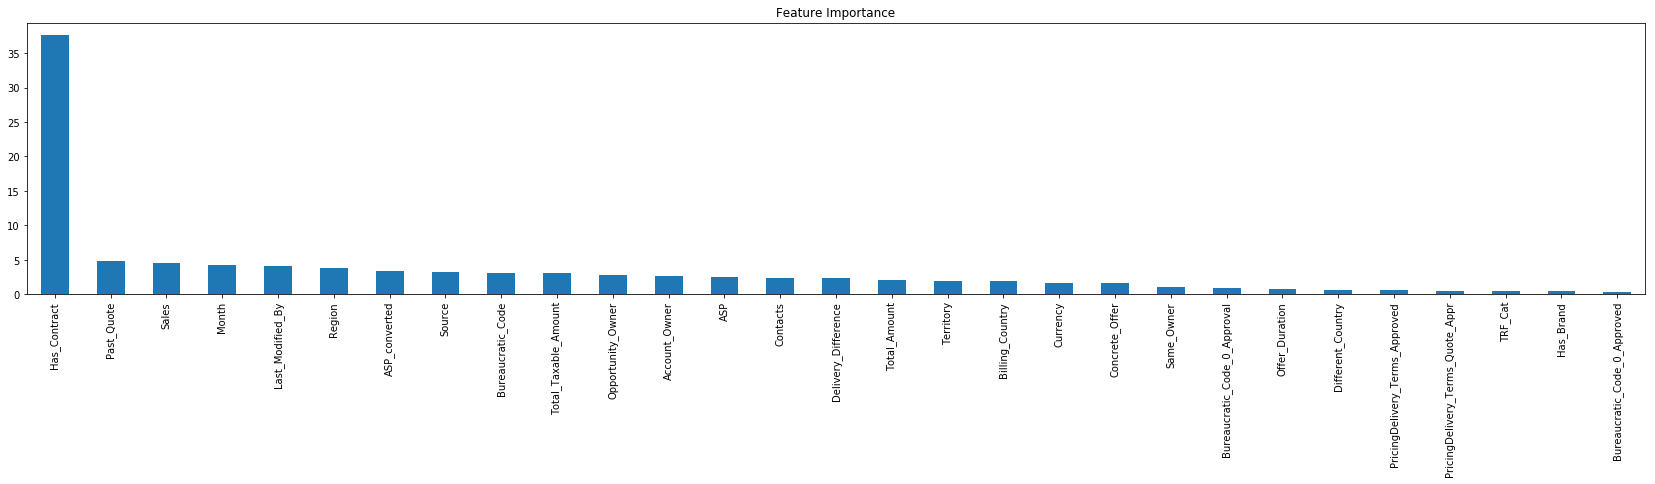

In [78]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
print len(predictors)
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:29]
plt.rcParams['figure.figsize'] = 29, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [79]:
bad = x_test_pred[(x_test_pred.Prediction > 0.5) & (x_test_pred.Stage == 0) | (x_test_pred.Prediction < 0.5) & (x_test_pred.Stage == 1)]

In [80]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model.predict_proba(validation.drop(leak, axis = 1))[:,1]

# agrupo por Opportunity_ID para dar una sola prediccion por solicitud

pred = pd.DataFrame(pred, index = validation.index, columns = ["Prediction"])
validation = validation.join(pred)

answer = pd.DataFrame(validation.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [81]:
prev = pd.read_csv("best/modellgbold_pred.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9922084398778014

In [82]:
prev = pd.read_csv("best/model_xgb_pred.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9909853386236175

In [83]:
prev = pd.read_csv("best/modelada_pred.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9936990632746543

In [84]:
prev = pd.read_csv("best/modelcat_pred.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9976623754253415

In [85]:
prev = pd.read_csv("best/avg_lgb_xgb_ada_cat.csv", names=["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9962809438645919

In [86]:
answer.to_csv("fabri/catb3.csv", header = False, index = False)

In [51]:
lgbm = pd.read_csv("fabri/lgbm.csv", names=["Id", "LGBM"])

In [52]:
xgb = pd.read_csv("fabri/xgb.csv", names=["Id", "XGB"]).drop("Id", axis=1)

In [53]:
catb = pd.read_csv("fabri/catb2.csv", names=["Id", "CATB"]).drop("Id", axis=1)

In [54]:
adab = pd.read_csv("fabri/adab2.csv", names=["Id", "ADAB"]).drop("Id", axis=1)

In [55]:
full = lgbm.join(xgb).join(catb).join(adab).drop('LGBM', axis=1)

In [56]:
full.XGB.corr(full.CATB)

0.9940014543236237

In [57]:
full.XGB.corr(full.ADAB)

0.9970269542862235

In [58]:
full.ADAB.corr(full.CATB)

0.9924745865832904

In [59]:
full.head()

,Id,XGB,CATB,ADAB
0,10689,0.997061,0.998040,0.998755
1,10690,0.992818,0.996455,0.997990
2,10691,0.975783,0.986605,0.985792
3,10692,0.976373,0.989770,0.997229
4,10693,0.972380,0.953184,0.995830


In [60]:
full["Final"] = full.apply(lambda x: calculate([x['CATB'], x['ADAB']], 0.001), axis=1)

In [48]:
def calculate(preds, offset):
    mean = sum(preds) / len(preds)
    return mean
    #return np.clip(mean, 0 + offset, 1 - offset)

In [548]:
full["Final"] = full.apply(lambda x: calculate([x['LGBM'], x['XGB'], x['CATB']]), axis=1)

In [61]:
full[["Id", "Final"]].to_csv("fabri/avg_adab2_catb2.csv", header = False, index = False)

In [563]:
modellgbold = pd.read_csv("best/modellgbold_pred.csv", names=["Id", "LGBOLD"])

In [564]:
modelcat = pd.read_csv("best/modelcat_pred.csv", names=["Id", "CATB"]).drop("Id", axis=1)

In [565]:
modelada = pd.read_csv("best/modelada_pred.csv", names=["Id", "ADA"]).drop("Id", axis=1)

In [566]:
modelxgb = pd.read_csv("best/model_xgb_pred.csv", names=["Id", "XGB"]).drop("Id", axis=1)

In [567]:
fullmodels = modellgbold.join(modelcat).join(modelada).join(modelxgb)

In [602]:
fullmodels.head(10)

,Id,LGBOLD,CATB,ADA,XGB,Final
0,10689,0.997994,0.997574,0.999471,0.996613,0.997913
1,10690,0.991791,0.994675,0.997299,0.979186,0.990738
2,10691,0.992083,0.969127,0.994164,0.908210,0.965896
3,10692,0.926446,0.978247,0.996771,0.980566,0.970507
4,10693,0.979495,0.967347,0.984526,0.968971,0.975085
5,10694,0.979495,0.976924,0.980587,0.928566,0.966393
6,10695,0.011361,0.000530,0.027921,0.066383,0.026549
7,10696,0.007405,0.000426,0.038997,0.063532,0.027590
8,10697,0.024714,0.001642,0.080582,0.142011,0.062237
9,10698,0.004736,0.000530,0.014155,0.009440,0.007215


In [601]:
fullmodels["Final"] = fullmodels.apply(lambda x: calculate([x['LGBOLD'], x['XGB'], x['ADA'], x['CATB']], 0.0005), axis=1)

In [1]:
fullmodels[["Id", "Final"]].to_csv("fabri/testsubimission9.csv", header = False, index = False)

NameError: name 'fullmodels' is not defined

In [ ]:
target_ensamble = ["Stage", "Opportunity_ID"]

ens_parameters = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': True,
    'boosting': 'gbdt',
    'feature_fraction': 0.3,
    'learning_rate': 0.05    
}

full_data = lgb.Dataset(data = df_ensamble.drop(target_ensamble, axis = 1), label = df_ensamble.Stage)
cv_results = lgb.cv(ens_parameters, full_data, num_boost_round = 1000, nfold = 5, early_stopping_rounds = 100)
cv_results["binary_logloss-mean"][-1]